In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0)
weights = []

In [8]:
for epoch in range(1, 10):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 300 == 299:
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i + 1, running_loss / 300))
            running_loss = 0.0
    
    if epoch % 3 == 0:
        torch.save(model.state_dict(), f'model_v1_epoch_{epoch}')
        weights.append(f'model_v1_epoch_{epoch}')


print('Finished Training')

[1,   300] loss: 2.301
[1,   600] loss: 2.300
[1,   900] loss: 2.297
[2,   300] loss: 2.294
[2,   600] loss: 2.293
[2,   900] loss: 2.290
[3,   300] loss: 2.287
[3,   600] loss: 2.284
[3,   900] loss: 2.280
[4,   300] loss: 2.275
[4,   600] loss: 2.269
[4,   900] loss: 2.263
[5,   300] loss: 2.252
[5,   600] loss: 2.241
[5,   900] loss: 2.225
[6,   300] loss: 2.199
[6,   600] loss: 2.165
[6,   900] loss: 2.113
[7,   300] loss: 2.015
[7,   600] loss: 1.885
[7,   900] loss: 1.713
[8,   300] loss: 1.525
[8,   600] loss: 1.362
[8,   900] loss: 1.208
[9,   300] loss: 1.078
[9,   600] loss: 0.957
[9,   900] loss: 0.882
Finished Training


In [21]:
def calculate_tracin_score(
    model: torch.nn.Module,
    weights_paths: [str or Path],
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    work_dir: str or Path,
    nu_for_each_epoch: None
):
        
    LR = nu_for_each_epoch

    score_matrix = np.zeros((len(train_dataloader), len(test_dataloader)))
    
    for train_id, (x_train, y_train) in enumerate(train_dataloader):
        if train_id % 50 == 0:
            print('Train:', round(train_id / 500 * 100), '%')
        for test_id, (x_test, y_test) in enumerate(test_dataloader):
            grad_sum = 0
            
            for w in weights_paths:
                model = Net()
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                y_pred = model(x_train) # pred
                loss = criterion(y_pred, y_train)
                loss.backward() # back
                train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])
 
                model = Net()
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                y_pred = model(x_test) # pred
                loss = criterion(y_pred, y_test)
                loss.backward() # back
                test_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])

                grad_sum += LR * np.dot(train_grad, test_grad) # scalar mult, TracIn formula
            
            score_matrix[train_id][test_id] = grad_sum
    
    
    return score_matrix

In [22]:
import numpy as np

In [23]:
# We will use subsets of train and test to save time
train_subset = torch.utils.data.Subset(trainset, range(500)) 
test_subset =  torch.utils.data.Subset(testset, range(50))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=1,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(test_subset, batch_size=1,
                                         shuffle=False)


matrix = calculate_tracin_score(model=Net(), 
                       weights_paths=weights, 
                       train_dataloader=trainloader, test_dataloader=testloader, 
                       work_dir=None, nu_for_each_epoch=0.001) # learning rate

Train: 0 %
Train: 10 %
Train: 20 %
Train: 30 %
Train: 40 %
Train: 50 %
Train: 60 %
Train: 70 %
Train: 80 %
Train: 90 %


In [29]:
import matplotlib.pyplot as plt
def imshow(imgs):
    fig = plt.figure(figsize=(8, 2))

    fig.add_subplot(1, 3, 1)
    plt.imshow(imgs[0], cmap='gray', interpolation='none') # train observation
    fig.add_subplot(1, 3, 2)
    plt.imshow(imgs[1], cmap='gray', interpolation='none') # highest TracIn on test
    fig.add_subplot(1, 3, 3)
    plt.imshow(imgs[2], cmap='gray', interpolation='none') # lowest TracIn on test
    plt.show()

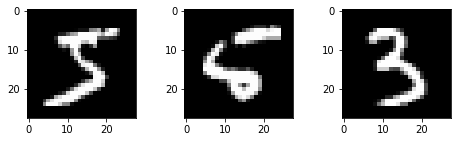

	 5 		 5 			 3


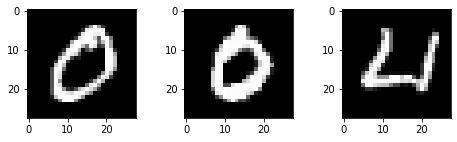

	 0 		 0 			 4


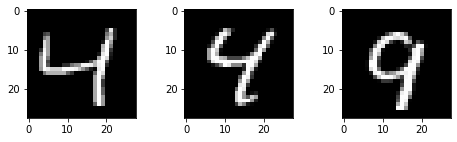

	 4 		 4 			 9


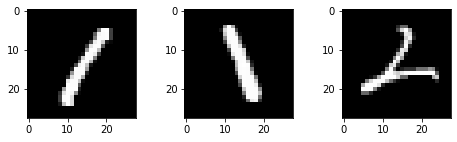

	 1 		 1 			 2


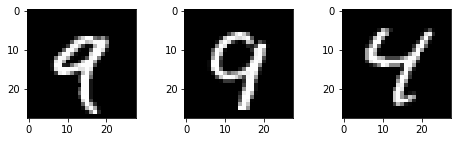

	 9 		 9 			 4


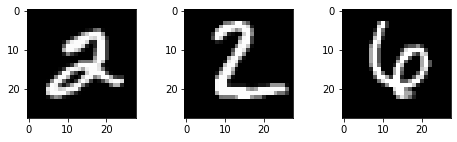

	 2 		 2 			 6


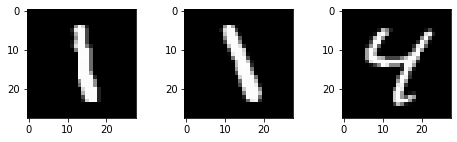

	 1 		 1 			 4


In [33]:
for train_id, (x_train, y_train) in enumerate(trainloader):
    row = matrix[train_id, :]
    max_ind = row.argmax()
    min_ind = row.argmin()
    imshow([train_subset[train_id][0][0], test_subset[max_ind][0][0], test_subset[min_ind][0][0]])
    print('\t', train_subset[train_id][1], '\t\t', test_subset[max_ind][1], '\t\t\t', test_subset[min_ind][1])
    if train_id > 5:
      break